# Model local files vs. country playlist

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Read data

In [2]:
df_local = pd.read_pickle("../Local/extracted data/2025_01_07_local_music_librosa_features.pkl")
df_country = pd.read_pickle("../Youtube/extracted data/2025_01_08_Country_Music_Playlist_2024.pkl").rename(columns={'title': 'track_name'})

In [3]:
# Combine
# List of common columns we want to keep (librosa features + track_name)
common_cols = ['track_name', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 
                  'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 
                  'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 
                  'mfcc_17', 'mfcc_18', 'mfcc_19', 'spectral_centroid', 'chroma_0', 
                  'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 
                  'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 
                  'chroma_11', 'tempo']

# Create new dataframes with only the common columns
df_country_subset = df_country[common_cols].copy()
df_local_subset = df_local[common_cols].copy()

# Add 'local' column
df_country_subset['local'] = 0
df_local_subset['local'] = 1

# Combine the dataframes
df_combined = pd.concat([df_country_subset, df_local_subset], ignore_index=True)

## Model

### Prep

In [26]:
# Feat cols
music_feat_cols = [col for col in common_cols if col != 'track_name']

# Step 1: Prepare the data
X = df_combined[music_feat_cols]
y = df_combined['local']

# Hold out 5 songs from each class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, stratify=y, random_state=42)

In [27]:
# CV GS
# Step 2: Perform cross-validated grid search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

In [28]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

In [29]:
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [30]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [32]:
results_df = pd.DataFrame(grid_search.cv_results_)

In [35]:
results_df.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,0.296008,0.011361,0.003391,0.000489,0.1,4,200,1.0,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.958333,0.915493,0.943662,0.887324,0.901408,0.921244,0.026288,1
44,0.369412,0.010808,0.003391,0.000798,0.1,4,300,1.0,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.958333,0.887324,0.957746,0.901408,0.901408,0.921244,0.030481,1
52,0.359239,0.014582,0.003590,0.000798,0.1,5,300,0.9,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.916667,0.901408,0.929577,0.929577,0.915493,0.918545,0.010487,3
42,0.334705,0.010280,0.003192,0.000399,0.1,4,300,0.8,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.916667,0.901408,0.943662,0.915493,0.915493,0.918545,0.013760,3
39,0.265889,0.004306,0.003391,0.000489,0.1,4,200,0.8,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.916667,0.901408,0.943662,0.929577,0.901408,0.918545,0.016392,3


In [37]:
# Step 3: Train the model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [38]:
# Step 4: Predict on held-out songs
y_pred = best_model.predict(X_test)

In [39]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Accuracy on held-out songs: {accuracy:.2f}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
Accuracy on held-out songs: 0.80


In [44]:
# Step 5: Proba output
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of class 1

In [45]:
# Create a results dataframe
df_preds = pd.DataFrame({
    'track_name': df_combined.loc[X_test.index, 'track_name'],
    'actual': y_test,
    'predicted': y_pred_proba.round(),
    'probability': y_pred_proba.round(3)
})

In [47]:
# Add a 'correct' column
df_preds['correct'] = df_preds['actual'] == df_preds['predicted']

In [48]:
df_preds

,track_name,actual,predicted,probability,correct
14,Bryan Martin - We Ride (Official Music Video).mp3,0,0.0,0.001,True
102,Morgan Wallen - Whiskey Friends.mp3,0,0.0,0.391,True
320,Pogo - Star Charts - 03 Cosgrove.mp3,1,1.0,0.994,True
300,Happy Horse Goes To Happy Town _ Pogo_27029862...,1,1.0,0.962,True
92,Morgan Wallen - I Wrote The Book (Lyric Video)...,0,0.0,0.280,True
185,07 Bagels in Kiev.mp3,1,0.0,0.313,False
292,08 Under Control 1.m4a,1,1.0,0.962,True
178,11 Brother Sport.m4a,1,1.0,0.993,True
162,08 Loch Raven.m4a,1,0.0,0.071,False
106,Morgan Wallen – Wasted On You (Audio Only).mp3,0,0.0,0.041,True


In [52]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[4, 0],
       [2, 4]], dtype=int64)

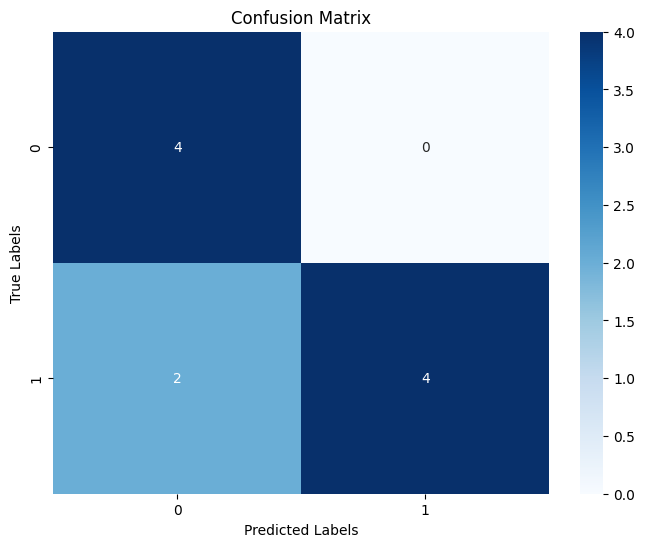

In [53]:
# Create a heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()